In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD,RMSprop
from keras.callbacks import *
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
import os,sys
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import re
import collections
import sklearn
import commonutils as cu
import model_specs
from sklearn import svm
from sklearn.externals import joblib

## Exploring data augmentation

In [10]:
# Might want to tune these parameters
train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                                   rotation_range=0, width_shift_range=0.2,
                                   height_shift_range=0.1,zoom_range=0.1,
                                   horizontal_flip=True, vertical_flip = True, fill_mode='constant')
test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

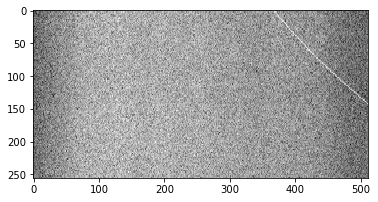

In [60]:
sampleimg = load_img('../data/imagesDataset_512x256_8/train/3-narrowbanddrd/000050.jpg',grayscale=True)# PIL image
xsample = img_to_array(sampleimg)  # this is a Numpy array with shape (3, 512, 256)
xsample = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 512, 256)
plt.set_cmap('gray')
plt.imshow(sampleimg)
plt.show()

In [5]:
# # Create a sample dataset array for fitting whitening / normalization parameters
# #(linux command for putting all images in one place) 
# # find train -name '*.jpg' -type f -exec cp {} . \;
trainImgDir = '../data/imagesDataset_512x256_8/train_one_folder/'
files = [f for f in os.listdir(trainImgDir) if f.endswith('.jpg')]
size = img_to_array(load_img(os.path.join(trainImgDir,files[0]),grayscale=True)).shape
trainDataArray = np.zeros((len(files)//5,)+size) # Only 1/10 the data, because memory constraints
for i in range(len(files)//5):
    trainDataArray[i] = img_to_array(load_img(os.path.join(trainImgDir,files[i]),grayscale=True))

In [6]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
train_datagen.fit(trainDataArray)
test_datagen.fit(trainDataArray)
i = 0
for batch in test_datagen.flow(x, batch_size=1,
                          save_to_dir='previewtest', save_prefix='signaltest', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

NameError: name 'x' is not defined

In [54]:
# No way we can run PCA on these size images on a single machine. Would need 128Gb memory
flat_x.shape[1]**2*8/(1024**3)

128

In [44]:
# Matrix size that'll take up 1GB
np.sqrt((1024**3)/8)

11585.237502960395

## Picking an image from the generator

In [3]:
# Might want to tune these parameters
train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                                   rotation_range=0, width_shift_range=0.2,
                                   height_shift_range=0.1,zoom_range=0.1,
                                   horizontal_flip=True, vertical_flip = True, fill_mode='constant')
test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

# # Create a sample dataset array for fitting whitening / normalization parameters
# #(linux command for putting all images in one place) 
# # find train -name '*.jpg' -type f -exec cp {} . \;
trainImgDir = '../data/imagesDataset_512x256_8/train_one_folder/'
files = [f for f in os.listdir(trainImgDir) if f.endswith('.jpg')]
size = img_to_array(load_img(os.path.join(trainImgDir,files[0]),grayscale=True)).shape
trainDataArray = np.zeros((len(files)//5,)+size) # Only 1/10 the data, because memory constraints
for i in range(len(files)//5):
    trainDataArray[i] = img_to_array(load_img(os.path.join(trainImgDir,files[i]),grayscale=True))
    
train_datagen.fit(trainDataArray)
test_datagen.fit(trainDataArray)

datasetPath = "../data/imagesDataset_512x256_8/train/"
valDataPath = "../data/imagesDataset_512x256_8/validation/"
classList = ['0-noise','2-narrowband','3-narrowbanddrd','5-squiggle']
batch_size = 8
train_generator = train_datagen.flow_from_directory(directory=datasetPath,batch_size=batch_size,class_mode='categorical',
                            classes=classList,target_size=(256,512),color_mode='grayscale')
validation_generator = test_datagen.flow_from_directory(directory=valDataPath,batch_size=batch_size,
        class_mode='categorical',classes=classList,target_size=(256,512),color_mode='grayscale')

Found 7584 images belonging to 4 classes.
Found 1498 images belonging to 4 classes.


In [5]:
a = validation_generator.next()

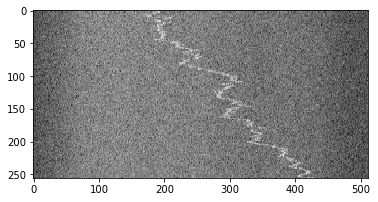

In [9]:
x = np.expand_dims(a[0][2],axis=0)
# Show the image from the validation generator
plt.imshow(x[0,:,:,0])
plt.set_cmap('gray')
plt.show()

## Examining trained model

In [10]:
modelPath = '../savedModels/setiNet_256x512_4class_adamaugment2dropout0.6lr5e-05anneal0.07.hdf5'
model = keras.models.load_model(modelPath)

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 512, 8)       80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 512, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 256, 512, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 256, 8)       584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 256, 8)       32        
_________________________________________________________________
activation_2 (Activation)    (None, 128, 256, 8)       0         
__________

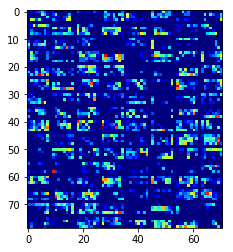

In [18]:
# Check activations for the image
act = cu.datautils.modelActivations(model=model,layer_name='activation_7',input=x,show=True)

In [14]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[0:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

W shape :  (3, 3, 64)


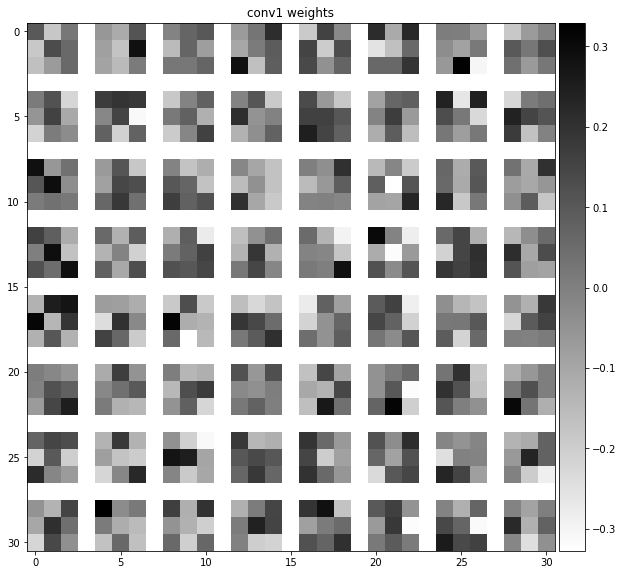

In [15]:
# Visualize weights
W = model.get_layer(name='conv2d_2').get_weights()[0]
nfilt = W.shape[2]*W.shape[3]
W = np.reshape(W,W.shape[0:2]+(nfilt,))
print("W shape : ", W.shape)

plt.figure(figsize=(10,20))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W, 8, 8), cmap=cm.binary)
plt.show()

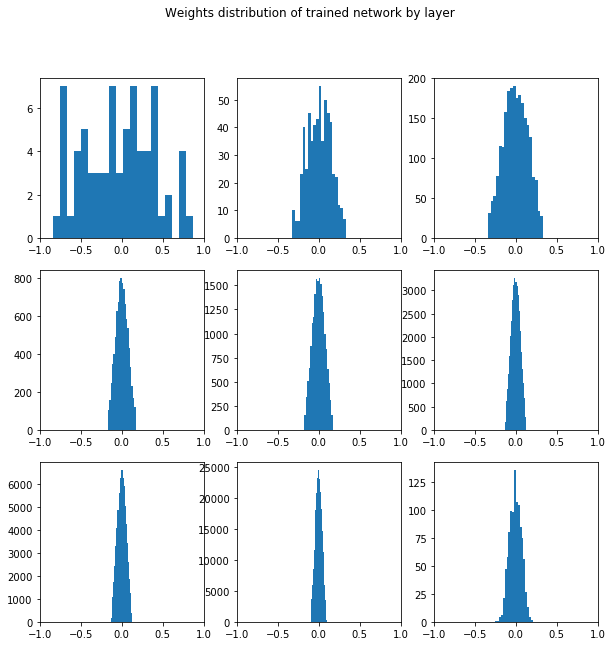

In [18]:
# Weights distribution of trained network 
layerNames = ['conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5',
              'conv2d_6','conv2d_7','dense_1','dense_2']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Weights distribution of trained network by layer')
for i in range(len(layerNames)):
    pltIndex = int('33{}'.format(i+1))
    plt.subplot(pltIndex)
    plt.xlim(-1,1)
    W = model.get_layer(name=layerNames[i]).get_weights()[0]
    plt.hist(W.flatten(),bins=20)
plt.show()

/home/cs341seti/cs341-ibm-seti/commonutils/datautils.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("co...)`
  model_selection = Model(input=model.input, output=model.get_layer(layer_name).output)


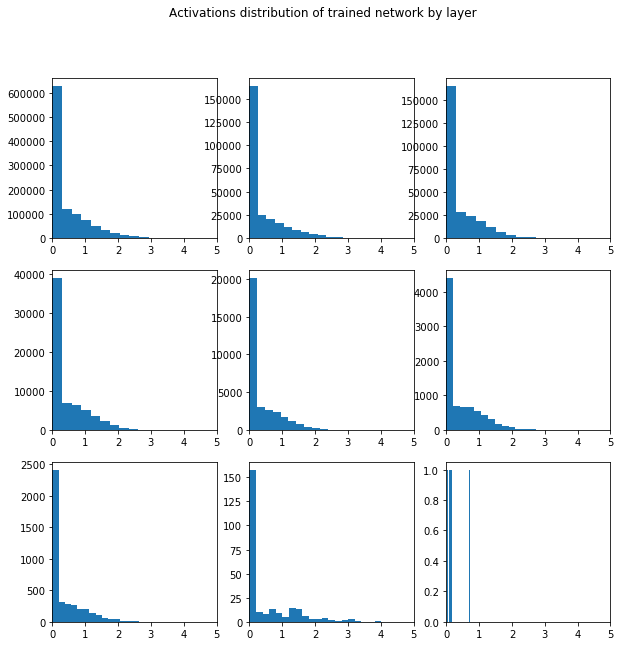

In [19]:
# Activations distribution of trained network 
layerNames = ['activation_1','activation_2','activation_3','activation_4',
              'activation_5','activation_6','activation_7','dense_1','dense_2']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Activations distribution of trained network by layer')
for i in range(len(layerNames)):
    pltIndex = int('33{}'.format(i+1))
    plt.subplot(pltIndex)
    plt.xlim((0,5))
    act = cu.datautils.modelActivations(model=model,layer_name=layerNames[i],input=x,show=False)
    plt.hist(act.flatten(),bins=20)
plt.show()

## Examine activation distributions at initialization

In [4]:
initialized_model = model_specs.setiNet.build((256,512,1),4,init='he_uniform')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 512, 8)       80        
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 512, 8)       32        
_________________________________________________________________
activation_9 (Activation)    (None, 256, 512, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 256, 8)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 256, 8)       584       
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 256, 8)       32        
_________________________________________________________________
activation_10 (Activation)   (None, 128, 256, 8)       0         
__________

In [31]:
a = initialized_model.get_layer(index=0)

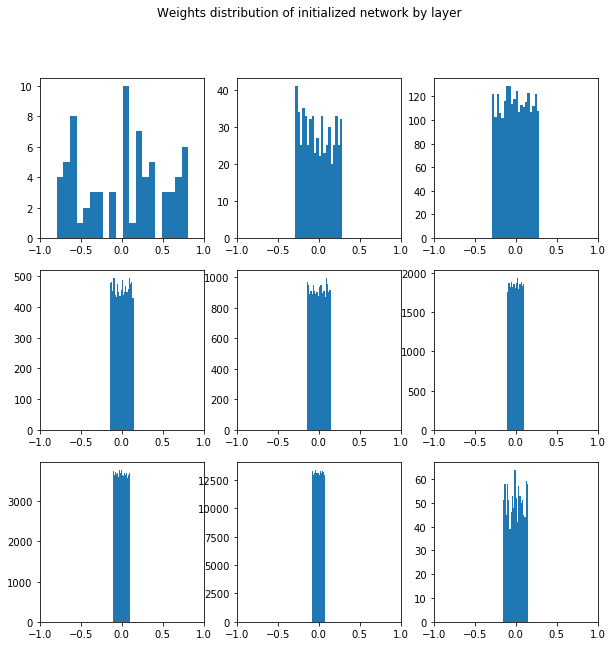

In [20]:
# Weights distribution of initialized network 
layerNames = ['conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5',
              'conv2d_6','conv2d_7','dense_1','dense_2']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Weights distribution of initialized network by layer')
for i in range(len(layerNames)):
    pltIndex = int('33{}'.format(i+1))
    plt.subplot(pltIndex)
    plt.xlim((-1,1))
    W = initialized_model.get_layer(name=layerNames[i]).get_weights()[0]
    plt.hist(W.flatten(),bins=20)
plt.show()

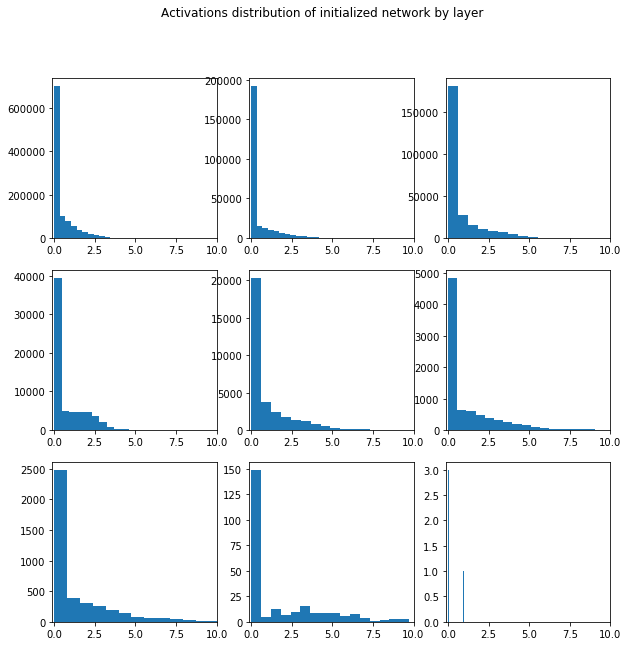

In [22]:
# Activations distribution of initialized network 
layerNames = ['activation_1','activation_2','activation_3','activation_4',
              'activation_5','activation_6','activation_7','dense_1','dense_2']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Activations distribution of initialized network by layer')
for i in range(len(layerNames)):
    pltIndex = int('33{}'.format(i+1))
    plt.subplot(pltIndex)
    plt.xlim((-0.1,10))
    act = cu.datautils.modelActivations(model=initialized_model,layer_name=layerNames[i],input=x,show=False)
    plt.hist(act.flatten(),bins=20)
plt.show()

In [ ]:
act = cu.datautils.modelActivations(model=model,layer_name='dense_2',input=x,show=False)

In [ ]:
plt.hist(act.flatten())
plt.show()

array([[ 0.02345068,  0.40760127,  0.52628797,  0.04266005]], dtype=float32)

## Evaluating models

In [32]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("../data/imagesDataset_512x256_8/imagesDataset_512x256_8.h5",
                                   subsetClasses=subsetClasses)

Dim of data: 256
Number of training images = 7584
Number of validation images = 1498
Number of test images = 905
Distribution in training data:
0 - 1526
1 - 1531
2 - 3018
3 - 1509
Distribution in validation data:
0 - 287
1 - 281
2 - 628
3 - 302
Distribution in test data:
0 - 185
1 - 185
2 - 349
3 - 186


In [24]:
np.random.uniform(0,5)

3.419423881986186

In [34]:
## Checking a saved CNN model
testPred = cu.modelutils.evaluateSavedModel(modelPath,dataset,mode='val')

Loaded in model..

Printing results on val dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.47      0.33      0.39       287
        1.0       0.41      0.18      0.25       281
        2.0       0.58      0.70      0.64       628
        3.0       0.34      0.46      0.39       302

avg / total       0.48      0.48      0.47      1498

[[ 95   3  46 143]
 [ 16  50 170  45]
 [ 42  59 442  85]
 [ 49  11 104 138]]
Test accuracy: 0.48 


In [129]:
## Using the datagen
validation_generator.classes[0:8]

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [137]:
model.evaluate_generator(validation_generator,steps=validation_generator.n//validation_generator.batch_size)

[1.453394632691505, 0.42953020134228187]